In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import Lasso, LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
import statistics

In [2]:
df = pd.read_csv('clean_kaggle_data_2021.csv')
df = df.iloc[1:]
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"
5,781,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"30,000-39,999"


## 1 Data Cleaning

### 1) Remove useless features

In [3]:
print(df["Q7_OTHER"].loc[df["Q7_OTHER"].first_valid_index()])

Other


There are many multiple choices questions in the survey, and the option "OTHER" seems not have meaning. The participants also did not specifiy it, so remove all columns contains "OTHER".  
Remove the features that are no longer of useful since they don't show anything discernable or they've been aggregating into another feature. Response time is not related to target variable. 'Q25' and 'Q25_buckets' are removed because 'Q25_Encoded' can replace them.

In [4]:
df = df[df.columns.drop(list(df.filter(regex='OTHER')))]
target = df['Q25_buckets']
features_to_drop = ['Time from Start to Finish (seconds)','Q25','Q25_buckets']
df.drop(labels=features_to_drop, axis=1, inplace=True)
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q25_Encoded
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6.0
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,NaN,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,3.0
5,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,NaN,NaN,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


### 2) Encode the categorical data  
Selecting all columns with categorical responses. Count and dealt with the missing values.

In [5]:
# Select categorical columns
categorical = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8','Q11','Q13','Q15','Q20','Q21','Q22','Q23','Q26','Q28','Q33','Q35','Q41']
columns = list(df.columns)
multi_choices = [x for x in columns if x not in categorical]
multi_choices.remove('Q25_Encoded')
# Count missing values
df[categorical].isna().sum()

Q1         0
Q2         0
Q3         0
Q4         0
Q5         0
Q6         0
Q8       961
Q11      961
Q13      961
Q15      961
Q20        0
Q21        0
Q22        0
Q23        0
Q26      208
Q28    12264
Q33    10735
Q35    13154
Q41     1965
dtype: int64

From the result above, columns 'Q8','Q11','Q13','Q15','Q26','Q28','Q33','Q35','Q41' have missing values. Next, I will replace the missing value of these columns one by one.

In [6]:
missing_values = ['Q8','Q11','Q13','Q15','Q26','Q28','Q33','Q35','Q41']
for x in missing_values:
    print(df[x].unique())

['Python' 'SQL' 'R' 'MATLAB' 'C' 'Javascript' 'C++' 'Julia' nan 'Other'
 'Java' 'Bash' 'Swift' 'None']
['A laptop'
 'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)'
 'A personal computer / desktop'
 'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)' 'Other' nan
 'None']
['2-5 times' 'Never' 'More than 25 times' 'Once' '6-25 times' nan]
['5-10 years' 'Under 1 year' 'I do not use machine learning methods'
 '10-20 years' '2-3 years' '1-2 years' '4-5 years' '3-4 years'
 '20 or more years' nan]
['$100-$999' '$0 ($USD)' '$1000-$9,999' '$1-$99' '$100,000 or more ($USD)'
 '$10,000-$99,999' nan]
[nan ' Google Cloud Platform (GCP) ' ' SAP Cloud ' ' Microsoft Azure '
 'They all had a similarly enjoyable developer experience'
 ' Amazon Web Services (AWS) ' ' Oracle Cloud ' ' Alibaba Cloud '
 'None were satisfactory' ' IBM Cloud / Red Hat ' ' Salesforce Cloud '
 'Other' ' Tencent Cloud ' ' VMware Cloud ']
[nan 'MySQL ' 'IBM Db2 ' 'PostgreSQL ' 'Google Cloud Firestore '

So for questions with a response, such as "None", "Never", replace the missing value with response like this. Since the participant chose not to answer the question, it is reasonable to assume the participant do not have any experience.  
For questions do not have such responses, replace the missing value with the mode as it identified the general level of all participants.  

In [7]:
df['Q8'].fillna('None',inplace=True)
df['Q11'].fillna('None',inplace=True)
df['Q13'].fillna('Never',inplace=True)
df['Q15'].fillna('I do not use machine learning methods',inplace=True)
fill = ['Q8','Q11','Q13','Q15','Q26','Q28','Q33','Q35','Q41']
df.fillna({x: df.loc[:,x].mode()[0] for x in fill}, inplace=True)
df[categorical].isna().sum()

Q1     0
Q2     0
Q3     0
Q4     0
Q5     0
Q6     0
Q8     0
Q11    0
Q13    0
Q15    0
Q20    0
Q21    0
Q22    0
Q23    0
Q26    0
Q28    0
Q33    0
Q35    0
Q41    0
dtype: int64

For the categorical questions, some responses are nominal, and some are ordinal. Separate the categorical features into groups, nominal and ordinal. Encoded nominal features with pandas.get_dummies, and merge them with the original dataset. Use LabelEncoder to encode ordinal features to numerical.

In [8]:
nominal = ['Q2','Q3','Q4','Q5','Q8','Q11','Q20','Q23','Q28','Q33','Q35','Q41']
ordinal = [x for x in categorical if x not in nominal]
# use pandas get_dummies feeding to the related columns to get the dummies
df_Q2 = pd.get_dummies(df['Q2'], prefix='Q2')
df_Q3 = pd.get_dummies(df['Q3'], prefix='Q3')
df_Q4 = pd.get_dummies(df['Q4'], prefix='Q4')
df_Q5 = pd.get_dummies(df['Q5'], prefix='Q5')
df_Q8 = pd.get_dummies(df['Q8'], prefix='Q8')
df_Q11 = pd.get_dummies(df['Q11'], prefix='Q11')
df_Q20 = pd.get_dummies(df['Q20'], prefix='Q20')
df_Q23 = pd.get_dummies(df['Q23'], prefix='Q23')
df_Q28 = pd.get_dummies(df['Q28'], prefix='Q28')
df_Q33 = pd.get_dummies(df['Q33'], prefix='Q33')
df_Q35 = pd.get_dummies(df['Q35'], prefix='Q35')
df_Q41 = pd.get_dummies(df['Q41'], prefix='Q41')
# use pandas concatenate to concatenate df with dummies
df = pd.concat([df, df_Q2, df_Q3, df_Q4, df_Q5, df_Q8, df_Q11, df_Q20, df_Q23, df_Q28, df_Q33, df_Q35, df_Q41], axis=1)
# drop the original columns 
df = df.drop(['Q2','Q3','Q4','Q5','Q8','Q11','Q20','Q23','Q28','Q33','Q35','Q41'],axis=1)
df = df[df.columns.drop(list(df.filter(regex='Other')))]

In [9]:
lb_make = LabelEncoder()
for col in ordinal:
    df[col] = lb_make.fit_transform(df[col])
df.head()

,Q1,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,...,Q35_Sisense,Q35_TIBCO Spotfire,Q35_Tableau,Q35_Tableau CRM,Q35_Thoughtspot,"Q41_Advanced statistical software (SPSS, SAS, etc.)","Q41_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q41_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q41_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q41_Local development environments (RStudio, JupyterLab, etc.)"
1,7,4,Python,R,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2,7,2,NaN,NaN,SQL,C,C++,Java,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,1,0,Python,NaN,NaN,NaN,C++,Java,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
4,6,2,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
5,6,5,Python,NaN,NaN,C,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


Now, there is no missing values for all categorical columns. Separate the categorical data into two group based on the answer type, nominal answers or interval and ordinal answers. Using "pd.get_dummies" to deal with the nomical data. And using LabelEncoder from scikit-learn to convert the rest ordinal data into numerical data.  

### 3) Encode Multiple Choices Data

Select each column for multiple choices questions, and encoded non-missing value with 1 and missing value with 0. Then, combined all columns for one question into one column.

In [10]:
print(df[multi_choices].isna().sum())

Q7_Part_1         2924
Q7_Part_2        11985
Q7_Part_3         8293
Q7_Part_4        13355
Q7_Part_5        12901
                 ...  
Q38_B_Part_7     15030
Q38_B_Part_8     14917
Q38_B_Part_9     15059
Q38_B_Part_10    14089
Q38_B_Part_11    12880
Length: 317, dtype: int64


In [11]:
for col in multi_choices:
    df.loc[df[col].notnull(), col] = 1
    df[col].fillna(0,inplace=True)
df.head()

,Q1,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,...,Q35_Sisense,Q35_TIBCO Spotfire,Q35_Tableau,Q35_Tableau CRM,Q35_Thoughtspot,"Q41_Advanced statistical software (SPSS, SAS, etc.)","Q41_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q41_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q41_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q41_Local development environments (RStudio, JupyterLab, etc.)"
1,7,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7,2,0,0,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,5,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
prefix = ['Q7','Q9','Q10','Q12','Q14','Q16','Q17','Q18','Q19','Q24',
          'Q27_A','Q29_A','Q30_A','Q31_A','Q32_A','Q34_A','Q36_A','Q37_A','Q38_A',
          'Q27_B','Q29_B','Q30_B','Q31_B','Q32_B','Q34_B','Q36_B','Q37_B','Q38_B','Q39','Q40','Q42']
for pre in prefix:
    col = df.columns[pd.Series(df.columns).str.startswith(pre)]
    df[pre] = df[col].sum(axis=1).astype(int)
    df.drop(col,axis=1,inplace=True)
df

,Q1,Q6,Q13,Q15,Q21,Q22,Q26,Q25_Encoded,Q2_Man,Q2_Nonbinary,...,Q30_B,Q31_B,Q32_B,Q34_B,Q36_B,Q37_B,Q38_B,Q39,Q40,Q42
1,7,4,0,6,4,5,4,2.0,1,0,...,0,0,0,0,0,0,0,2,6,6
2,7,2,3,8,2,1,0,6.0,1,0,...,0,1,4,2,1,1,1,0,3,1
3,1,0,3,7,2,0,0,0.0,1,0,...,0,3,3,2,1,1,1,1,1,2
4,6,2,2,6,2,0,0,3.0,1,0,...,0,1,1,1,1,0,1,0,2,3
5,6,5,3,1,4,6,5,3.0,1,0,...,0,0,0,0,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,3,0,4,0,1,4,4,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
15388,4,4,0,4,1,4,3,8.0,1,0,...,0,0,0,0,0,0,0,2,1,3
15389,3,0,3,0,1,4,5,1.0,1,0,...,0,0,0,0,0,0,0,2,7,3
15390,7,6,3,7,2,4,1,0.0,1,0,...,0,8,19,2,1,0,1,0,2,1


### 4) Reorder the columns of the Dataset

In [13]:
Prefix = ['Q2_','Q3_','Q4_','Q5_','Q8_','Q11_','Q20_','Q23_','Q28_','Q33_','Q35_','Q41_']
col_names = ['Q1']
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[0])]))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[1])]))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[2])]))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[3])]))
col_names.extend(('Q6','Q7'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[4])]))
col_names.extend(('Q9','Q10'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[5])]))
col_names.extend(('Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[6])]))
col_names.extend(('Q21','Q22'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[7])]))
col_names.extend(('Q24','Q26','Q27_A'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[8])]))
col_names.extend(('Q29_A','Q30_A','Q31_A','Q32_A'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[9])]))
col_names.append('Q34_A')
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[10])]))
col_names.extend(('Q36_A','Q37_A','Q38_A','Q27_B','Q29_B','Q30_B','Q31_B','Q32_B','Q34_B','Q36_B','Q37_B','Q38_B','Q39','Q40'))
col_names.extend(list(df.columns[pd.Series(df.columns).str.startswith(Prefix[11])]))
col_names.extend(('Q42','Q25_Encoded'))
df = df.reindex(columns=col_names)
df.head()

,Q1,Q2_Man,Q2_Nonbinary,Q2_Prefer not to say,Q2_Prefer to self-describe,Q2_Woman,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,...,Q38_B,Q39,Q40,"Q41_Advanced statistical software (SPSS, SAS, etc.)","Q41_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q41_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q41_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q41_Local development environments (RStudio, JupyterLab, etc.)",Q42,Q25_Encoded
1,7,1,0,0,0,0,0,0,0,0,...,0,2,6,0,0,0,0,1,6,2.0
2,7,1,0,0,0,0,0,0,0,0,...,1,0,3,1,0,0,0,0,1,6.0
3,1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,0.0
4,6,1,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,0,1,3,3.0
5,6,1,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,1,1,3.0


## 2 Exploratory data analysis and feature selection

### 1) Correlation Plot
The correlation plot is shown as a heatmap with range from -1 to 1. For column "Q30_B" as all of its entries are 0 so it does not have correlation with other features. However, this correlation plot is very redundant. Another plot which identifies the top 20 features that have strong correlation with salary "Q25_Encoded" will be plotted.

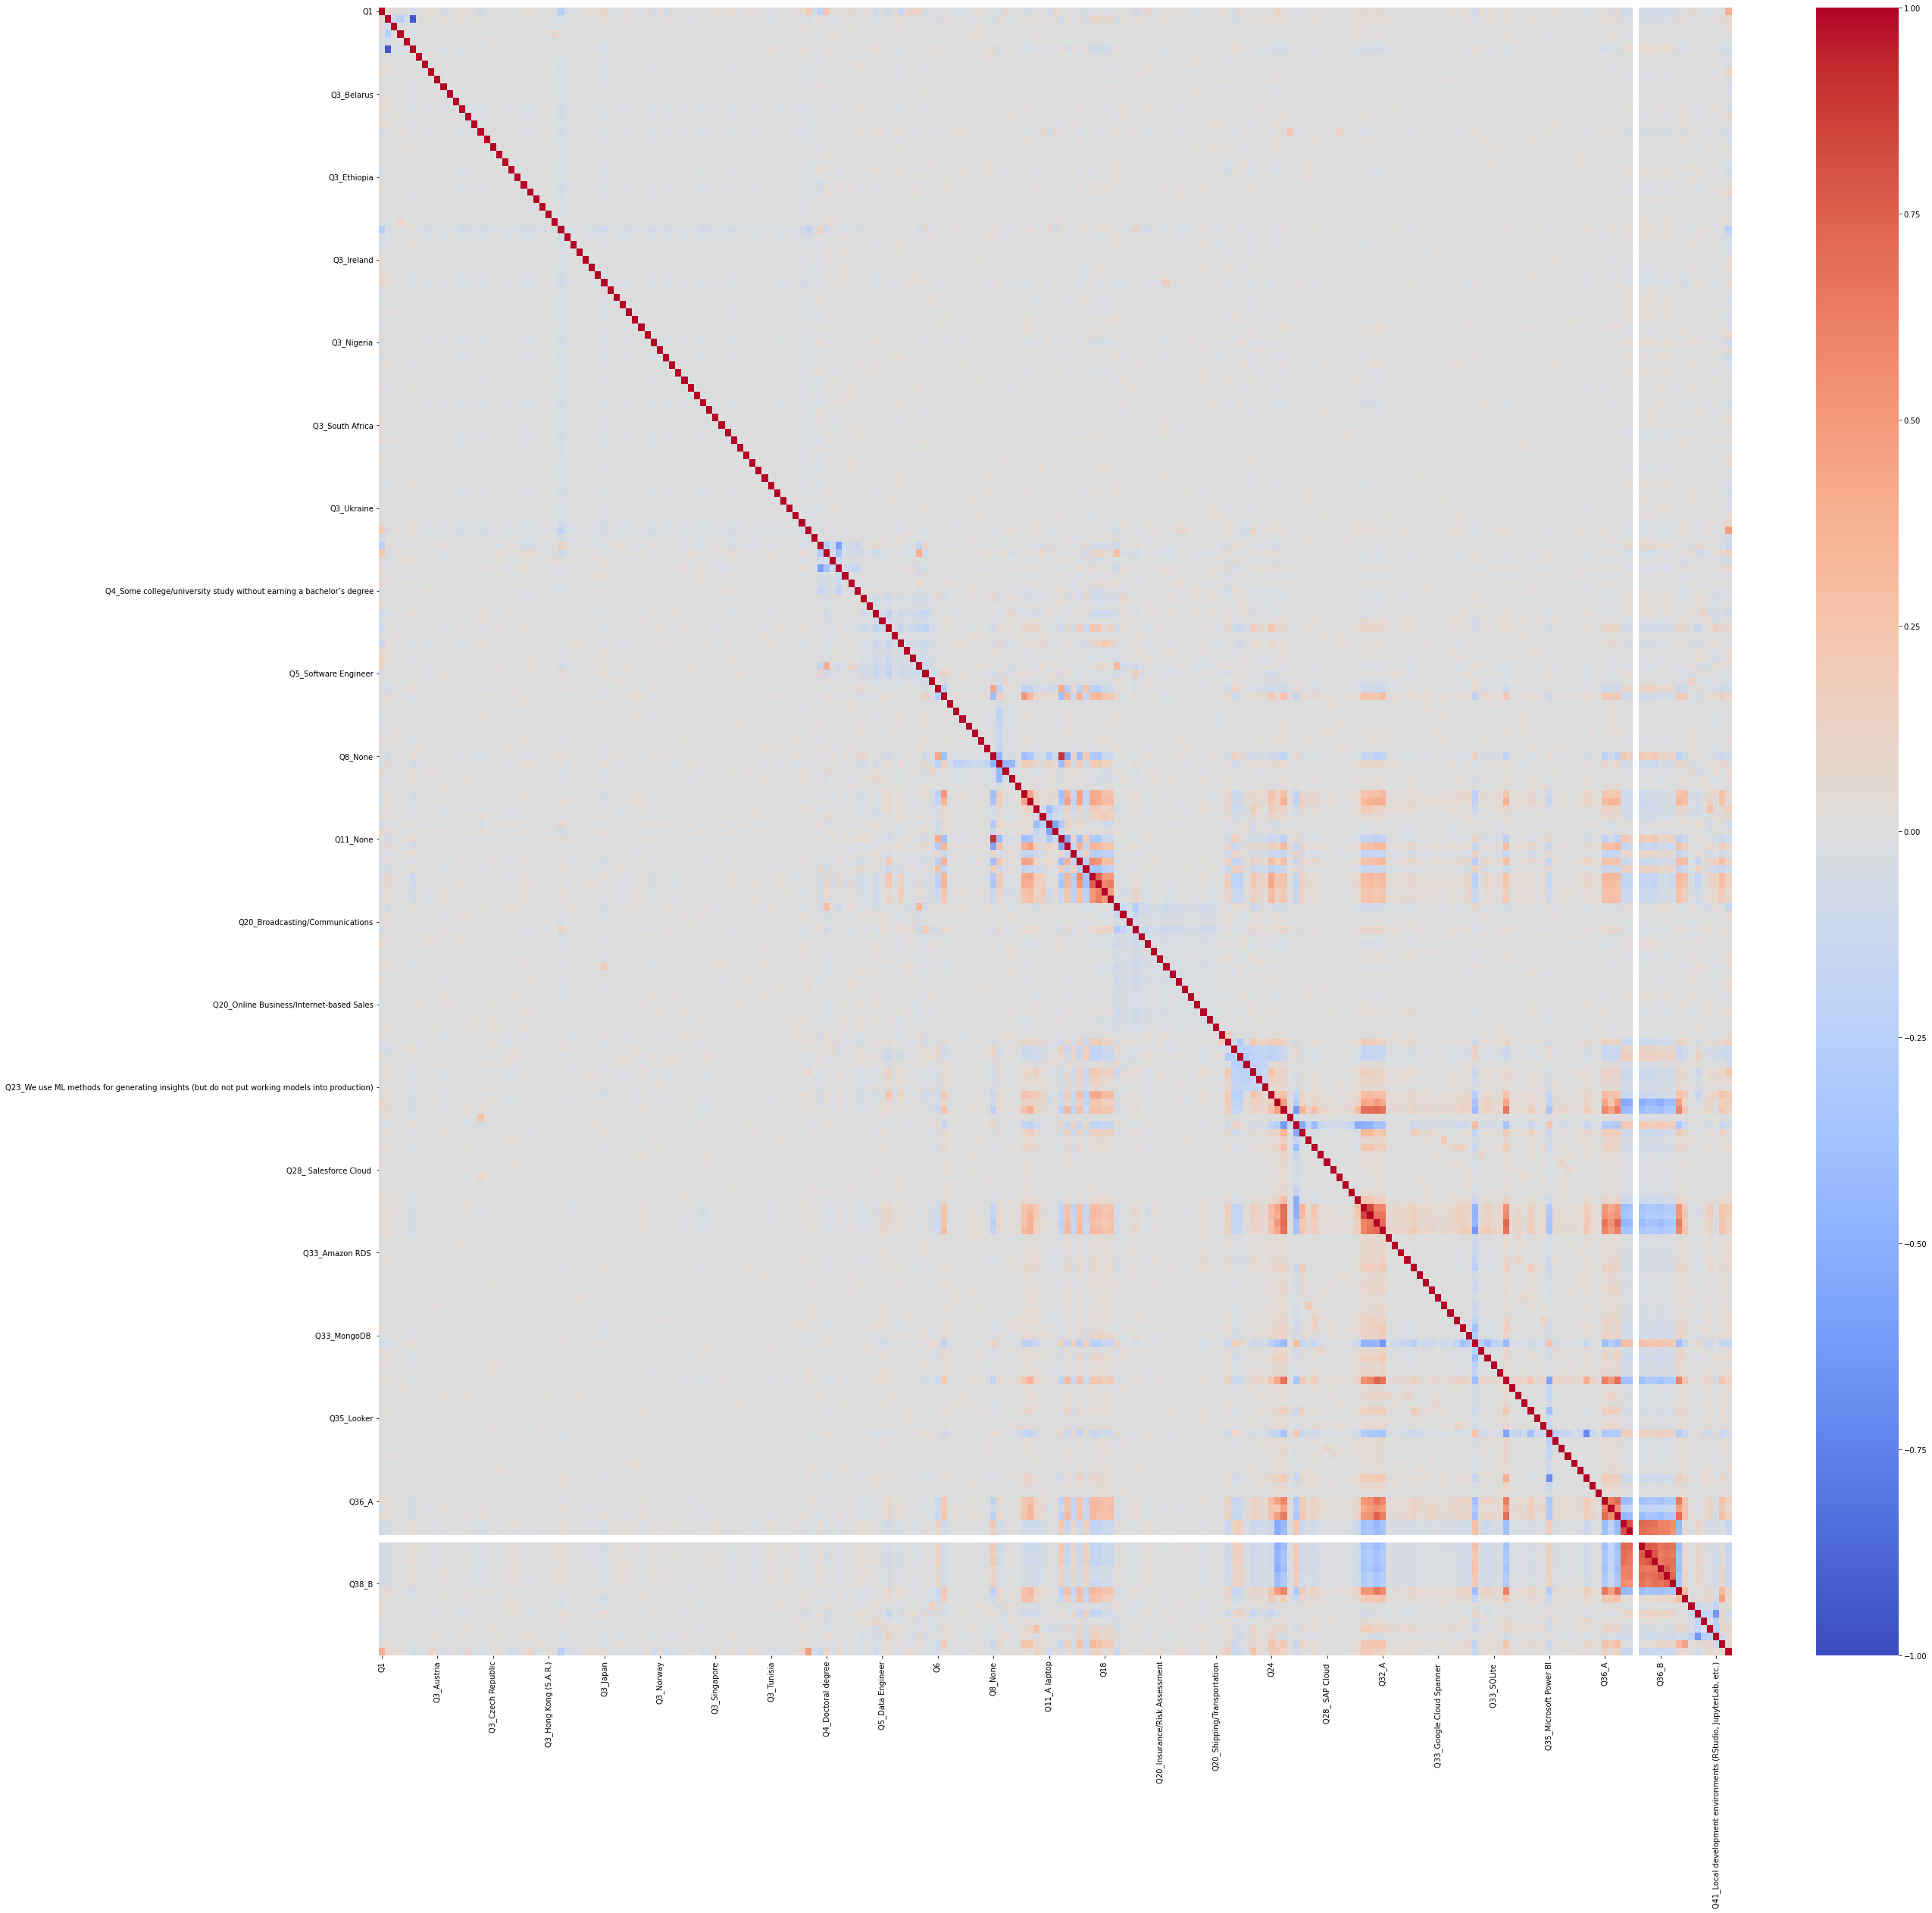

0    15391
Name: Q30_B, dtype: int64


In [14]:
ax = sns.heatmap(df.corr(),annot=False,fmt='.1g',vmin=-1, vmax=1, center= 0,cmap='coolwarm')
fig = plt.gcf()
fig.set_size_inches(40,40)
plt.show()
print(df['Q30_B'].value_counts())

### 2) Visualize the order of feature importance

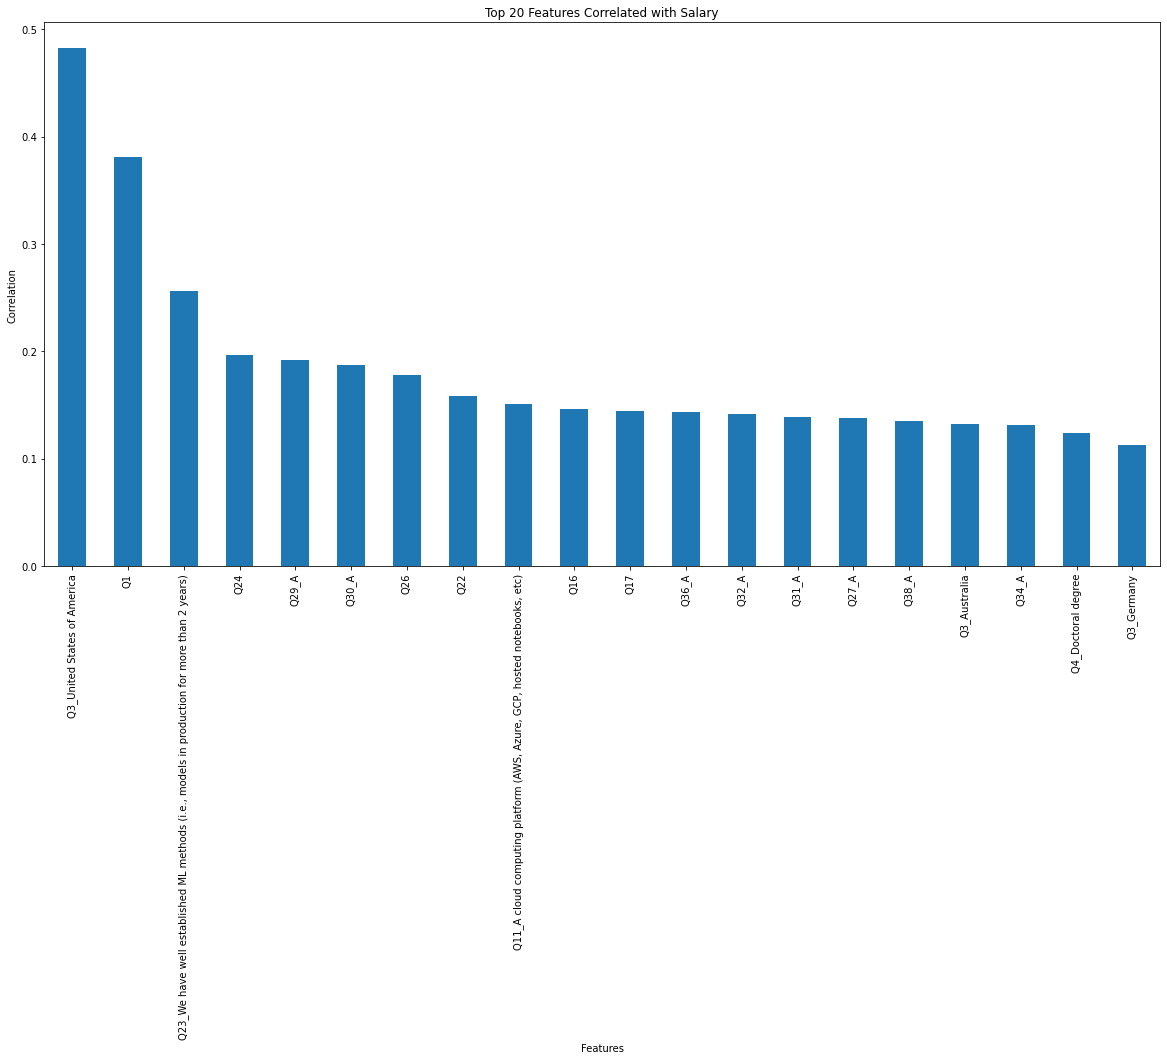

In [15]:
correlation_plot = df.corr()
target_corr = correlation_plot.shape[0]-1
correlation = correlation_plot.iloc[target_corr,0:-1].sort_values(ascending=False)

plt.figure(figsize=(20,10))
correlation.iloc[0:20].plot(kind='bar')
plt.title('Top 20 Features Correlated with Salary')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

From the plot, the most important feature is ‘Q3_United States of America’, with a correlation 0.482, which means if the participant from America, the person will have a great impact with the yearly salary. ‘Q1’, that represents age, follows next, with a correlation 0.381. ‘Q23_ We have well established ML methods’,’Q24’ and ‘Q29_A’ are the top 3-5 features, which represent whether employer incorporate machine learning methods in business, activities that make up an important part of role at work, and cloud computing products respectively.

In [16]:
print(correlation.iloc[0:20])

Q3_United States of America                                                                   0.482180
Q1                                                                                            0.381054
Q23_We have well established ML methods (i.e., models in production for more than 2 years)    0.256236
Q24                                                                                           0.196534
Q29_A                                                                                         0.191749
Q30_A                                                                                         0.187545
Q26                                                                                           0.178180
Q22                                                                                           0.158761
Q11_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)                       0.150570
Q16                                                                      

### 3) Feature Selection with Lasso Regression

After data cleaning, the dataset ends up with 218 features, which is a large number and may likely cause overfitting. Feature engineering should be applied on the dataset as the number of features need to be reduced to improve the performance of ordinal logistic regression algorithm by selecting the most related features. I fitted a Lasso Regression  on dataset and select those features that have a coefficient different from 0. However, after applied the Lasso Regression, there is only one feature that have coefficient equal to 0. Thus, I also applied PCA to reduce dimensionality. Now the number of features is 50.

In [17]:
x = pd.DataFrame(df.drop(labels=['Q25_Encoded'], axis=1))
y = pd.DataFrame(df['Q25_Encoded'])
pipeline = Pipeline([('model',Lasso())])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.0,10,0.5)},
                      cv = 10, scoring="neg_mean_squared_error",verbose=3
                      )
search.fit(x,y)
## https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END ................model__alpha=0.0;, score=-7.649 total time=   2.6s
[CV 2/10] END ................model__alpha=0.0;, score=-6.786 total time=   2.5s
[CV 3/10] END ................model__alpha=0.0;, score=-7.800 total time=   2.6s
[CV 4/10] END ................model__alpha=0.0;, score=-7.168 total time=   2.5s
[CV 5/10] END ................model__alpha=0.0;, score=-7.338 total time=   2.5s
[CV 6/10] END ................model__alpha=0.0;, score=-7.723 total time=   2.5s
[CV 7/10] END ................model__alpha=0.0;, score=-7.663 total time=   2.5s
[CV 8/10] END ................model__alpha=0.0;, score=-8.149 total time=   2.5s
[CV 9/10] END ................model__alpha=0.0;, score=-7.447 total time=   2.6s
[CV 10/10] END ...............model__alpha=0.0;, score=-7.759 total time=   3.1s
[CV 1/10] END ...............model__alpha=0.5;, score=-12.421 total time=   0.0s
[CV 2/10] END ...............model__alpha=0.5;

[CV 3/10] END ...............model__alpha=5.0;, score=-16.438 total time=   0.0s
[CV 4/10] END ...............model__alpha=5.0;, score=-16.222 total time=   0.0s
[CV 5/10] END ...............model__alpha=5.0;, score=-16.257 total time=   0.0s
[CV 6/10] END ...............model__alpha=5.0;, score=-16.403 total time=   0.0s
[CV 7/10] END ...............model__alpha=5.0;, score=-16.340 total time=   0.0s
[CV 8/10] END ...............model__alpha=5.0;, score=-16.197 total time=   0.0s
[CV 9/10] END ...............model__alpha=5.0;, score=-15.433 total time=   0.0s
[CV 10/10] END ..............model__alpha=5.0;, score=-15.665 total time=   0.0s
[CV 1/10] END ...............model__alpha=5.5;, score=-16.115 total time=   0.0s
[CV 2/10] END ...............model__alpha=5.5;, score=-15.422 total time=   0.0s
[CV 3/10] END ...............model__alpha=5.5;, score=-16.438 total time=   0.0s
[CV 4/10] END ...............model__alpha=5.5;, score=-16.222 total time=   0.0s
[CV 5/10] END ..............

GridSearchCV(cv=10, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])},
             scoring='neg_mean_squared_error', verbose=3)

In [18]:
search.best_params_

{'model__alpha': 0.0}

In [19]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(np.array(x.columns)[importance>0])
len(np.array(x.columns)[importance>0])

['Q1' 'Q2_Man' 'Q2_Nonbinary' 'Q2_Prefer not to say'
 'Q2_Prefer to self-describe' 'Q2_Woman' 'Q3_Algeria' 'Q3_Argentina'
 'Q3_Australia' 'Q3_Austria' 'Q3_Bangladesh' 'Q3_Belarus' 'Q3_Belgium'
 'Q3_Brazil' 'Q3_Canada' 'Q3_Chile' 'Q3_China' 'Q3_Colombia'
 'Q3_Czech Republic' 'Q3_Denmark' 'Q3_Ecuador' 'Q3_Egypt' 'Q3_Ethiopia'
 'Q3_France' 'Q3_Germany' 'Q3_Ghana' 'Q3_Greece' 'Q3_Hong Kong (S.A.R.)'
 'Q3_I do not wish to disclose my location' 'Q3_India' 'Q3_Indonesia'
 'Q3_Iran, Islamic Republic of...' 'Q3_Iraq' 'Q3_Ireland' 'Q3_Israel'
 'Q3_Italy' 'Q3_Japan' 'Q3_Kazakhstan' 'Q3_Kenya' 'Q3_Malaysia'
 'Q3_Mexico' 'Q3_Morocco' 'Q3_Nepal' 'Q3_Netherlands' 'Q3_Nigeria'
 'Q3_Norway' 'Q3_Pakistan' 'Q3_Peru' 'Q3_Philippines' 'Q3_Poland'
 'Q3_Portugal' 'Q3_Romania' 'Q3_Russia' 'Q3_Saudi Arabia' 'Q3_Singapore'
 'Q3_South Africa' 'Q3_South Korea' 'Q3_Spain' 'Q3_Sri Lanka' 'Q3_Sweden'
 'Q3_Switzerland' 'Q3_Taiwan' 'Q3_Thailand' 'Q3_Tunisia' 'Q3_Turkey'
 'Q3_Uganda' 'Q3_Ukraine' 'Q3_United Arab Emirat

217

In [20]:
x_std = StandardScaler().fit_transform(x)
x_std = pd.DataFrame(x_std, columns=x.columns)
x_shrink = x_std[np.array(x.columns)[importance>0]]
x_shrink

,Q1,Q2_Man,Q2_Nonbinary,Q2_Prefer not to say,Q2_Prefer to self-describe,Q2_Woman,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,...,Q37_B,Q38_B,Q39,Q40,"Q41_Advanced statistical software (SPSS, SAS, etc.)","Q41_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q41_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q41_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q41_Local development environments (RStudio, JupyterLab, etc.)",Q42
0,1.533653,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,-0.452580,0.985614,2.132483,-0.225696,-0.690287,-0.262759,-0.239661,1.079071,1.987516
1,1.533653,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,0.438187,0.320952,-0.876828,0.453772,4.430730,-0.690287,-0.262759,-0.239661,-0.926723,-0.763024
2,-1.078519,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,0.438187,0.320952,0.054393,-0.665369,-0.225696,1.448672,-0.262759,-0.239661,-0.926723,-0.212916
3,1.098291,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,0.320952,-0.876828,-0.105799,-0.225696,-0.690287,-0.262759,-0.239661,1.079071,0.337192
4,1.098291,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,-0.452580,0.054393,-0.105799,-0.225696,-0.690287,-0.262759,-0.239661,1.079071,-0.763024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15386,-0.207795,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,-0.452580,-0.876828,-1.224940,-0.225696,-0.690287,-0.262759,-0.239661,1.079071,-1.313132
15387,0.227567,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,-0.452580,0.985614,-0.665369,-0.225696,-0.690287,-0.262759,4.172564,-0.926723,0.337192
15388,-0.207795,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,-0.452580,0.985614,2.692054,-0.225696,-0.690287,3.805772,-0.239661,-0.926723,0.337192
15389,1.533653,0.466315,-0.055345,-0.113574,-0.039519,-0.438485,-0.038686,-0.093717,-0.11328,-0.04975,...,-0.448383,0.320952,-0.876828,-0.105799,-0.225696,1.448672,-0.262759,-0.239661,-0.926723,-0.763024


In [21]:
# reduce the number of feature to 50
pca = PCA(n_components = 50)
# apply pca to feature dataset 
pca.fit(x_shrink)
# transformed data
pca_x = pca.fit_transform(x_shrink)
# transfer to dataframe
pca_x = pd.DataFrame(pca_x)
pca_x

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.904260,0.188058,-0.820370,-0.422050,-0.332956,-0.576588,-0.199346,-1.040076,0.936243,-1.806362,...,0.536420,0.437217,-0.459579,0.184454,-0.269489,0.577169,-0.200755,-0.430642,-0.173822,-0.473355
1,-2.921440,0.336280,-0.265600,-0.380445,1.078217,-0.524877,-2.240551,0.788138,0.911373,0.328763,...,1.170499,-0.945999,-3.135284,-0.485175,-1.585939,1.150638,-0.755747,-2.240256,-0.023917,-0.062121
2,-2.934847,0.377028,1.278366,-2.317925,0.545243,-1.244195,0.680887,0.196366,0.542131,-1.085759,...,0.029032,-1.405416,0.208700,0.317174,0.521733,0.335467,-0.643446,-0.272178,-0.242598,0.196015
3,-2.425647,0.806223,-2.963908,1.869966,2.724046,-1.771458,0.934507,-0.162844,-1.281110,-0.740097,...,-1.476686,1.002493,-0.184457,0.057636,-1.812205,0.596848,-0.076836,-0.408030,-0.228011,1.356779
4,1.634926,-0.991885,-2.267977,1.559603,0.875523,0.050698,0.561579,-0.537855,-0.481461,-0.840267,...,-0.071894,0.447024,-0.376004,-0.364419,0.383238,-0.033240,0.452641,-0.423684,0.328083,0.308120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15386,0.083776,-0.162058,-3.674679,0.129562,-2.847344,-0.532259,-0.033437,-0.533126,0.201513,0.741320,...,0.628065,-0.298185,0.427339,0.022866,-0.393240,0.126817,-0.077113,0.142198,-1.093525,-0.425663
15387,3.751671,-1.017272,1.537729,-0.176496,-1.504851,-2.261084,-0.598632,1.803611,-0.865490,1.435454,...,-1.981435,2.043121,2.713618,-0.921776,0.872167,-0.752655,0.791278,0.658841,2.232401,0.092700
15388,4.887798,1.446539,0.891428,-1.772688,-0.908022,-0.615072,1.153198,-1.244736,-0.382826,-0.851057,...,-0.710579,0.314336,1.226786,0.515886,-0.113043,0.534046,-0.396495,-1.175044,-2.618581,-0.622983
15389,-7.729901,0.236703,3.259879,4.972244,3.425226,-1.925751,0.111047,-0.333746,-0.320107,-2.186560,...,-0.513989,-3.963329,2.489662,1.434719,0.152843,-1.560189,-0.552856,0.729799,-0.093339,0.552345


## 3 Model Implementation

The dataset is divided into training set x_train, y_train and test set x_test, y_test by test_size = 20%. Standardization is not performed on dataset since the dataset is already standardized before performing PCA.

In [22]:
# Split training and testing data by test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 0)

Ordinal logistic regression algorithm using 10-fold cross-validation is implemented in this section. The algorithm uses a feature dataset and a target array in fitting. The output is the probability matrix that each entry of features belongs to each of the salary buckets.

In [23]:
# Implement ordinal logistic regression algorithm
model = LogisticRegression()
# 10-fold cross-validation.
kf = KFold(n_splits=10) #n_splits previously n_folds
kf.get_n_splits(x_train) # 10-fold cross-validation.
# for loop setup
fold = 0
train_accur = []
test_accur = []
for train_index, test_index in kf.split(x_train):
    fold += 1
    x_train_kf, x_test_kf = x_train.values[train_index], x_train.values[test_index]
    y_train_kf, y_test_kf = y_train.values[train_index], y_train.values[test_index]

    # fit data using logistic regression model  
    model.fit(x_train_kf, y_train_kf)
    # prediction 
    train_predictions = model.predict(x_train_kf)
    test_predictions = model.predict(x_test_kf)
    # calculate accuracy using accuracy_score    
    test_accuracy = accuracy_score(y_test_kf, test_predictions) 
    train_accuracy = accuracy_score(y_train_kf, train_predictions) 

    test_accur.append(test_accuracy)
    train_accur.append(train_accuracy)
    print("Fold {0} |Train Accuracy: {1}|Validation Accuracy {2}".format(fold, train_accuracy, test_accuracy))   
    
probabilities = pd.DataFrame(model.predict_proba(x_test_kf),columns=range(1,16))


train_avg = statistics.mean(train_accur) 
test_avg = statistics.mean(test_accur)

train_var = statistics.variance(train_accur)
test_var = statistics.variance(test_accur)

print('\nAverage Train Accuracy', train_avg)
print('Average Validation  Accuracy', test_avg)
print('\nTrain Accuracy Variance', train_var)
print('Validation Accuracy Variance', test_var)

Fold 1 |Train Accuracy: 0.46958483754512637|Validation Accuracy 0.4788961038961039
Fold 2 |Train Accuracy: 0.47129963898916966|Validation Accuracy 0.45535714285714285
Fold 3 |Train Accuracy: 0.47143759588484796|Validation Accuracy 0.46303818034118605
Fold 4 |Train Accuracy: 0.4732424871401498|Validation Accuracy 0.46791226645004064
Fold 5 |Train Accuracy: 0.4719790632614385|Validation Accuracy 0.4476035743298132
Fold 6 |Train Accuracy: 0.4722497969497338|Validation Accuracy 0.46385052802599513
Fold 7 |Train Accuracy: 0.47152784044761303|Validation Accuracy 0.4703493095044679
Fold 8 |Train Accuracy: 0.4700839274433715|Validation Accuracy 0.4646628757108042
Fold 9 |Train Accuracy: 0.4754986012092771|Validation Accuracy 0.4281072298943948
Fold 10 |Train Accuracy: 0.47279126432632435|Validation Accuracy 0.45004061738424045

Average Train Accuracy 0.4719695053197052
Average Validation  Accuracy 0.45898178283941893

Train Accuracy Variance 2.777522651088795e-06
Validation Accuracy Variance 0

When fitting model, using KFold.split() split the training set x_train into new training set and validation set for each fold. This is the model accuracy on training set and validation set on each fold. The average accuracy on training set is 47.196% with a variance 2.7775e-06. The average accuracy on validation set is 45.898% with a variance 0.0002059.

In the next few steps, parameters ‘C’, ‘solver’ and ‘penalty’ are selected and tested. First, ‘C’ is the inverse of regularization, the smaller ‘C’ value means a stronger regularization. A list of ‘C’ values [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1] are used in model, and the bias-variance trade-off is calculated and plotted. From the graph, the bias decreases and the variance increases along with the increase in ‘C’ values. When ‘C’ is greater than 0.005, the extent of changes is very small. From the bias-variance trade-off, models perform better as the value of ‘C’ increases.
‘Solver’ is the Algorithm to use in the optimization problem. Different ‘solver’ algorithms (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’) are tested. The bias-variance trade-off is also calculated and plotted. From the graph, there is no difference when using ‘newton-cg’, ‘lbfgs’ and ‘sag’. At last, ‘penalty’ has been tuned. From the description of model, the ‘penalty’ can be one of the following: ‘l1’, ‘l2’, ‘elasticnet’ and ‘none’. Since the default ‘solver’ is ‘lbfgs’, only ‘l2’ and ‘none’ can be applied. After modelling, the bias-variance trade-off showed that these two kinds of ‘penalty’ have very similar performance. But ‘none’ has a slightly lower total error. Thus, the model with ‘penalty’ equals to ‘none’ performs better. 

In [24]:
def bias_square(y,predictions):
    # MSE = Bias^2 + Variance
    y = np.array(y)
    predictions = np.array(predictions)
    MSE = np.mean(np.square(np.subtract(y, predictions)))
    var = statistics.variance(predictions)
    return MSE-var

In [25]:
# tune hyperparameter
def run_kfold(X_train, y_train, C_input, penalty_input, solver_input):
    model = LogisticRegression(C=C_input,penalty=penalty_input,solver=solver_input )
    # 10-fold cross-validation.
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X_train)
    # for loop setup
    fold = 0
    test_accur = []
    train_accur = []
    bias_fold = []
    variance_fold = []
    for train_index, test_index in kf.split(X_train):
        fold += 1
        
        X_train_kf, X_test_kf = X_train.values[train_index], X_train.values[test_index]
        y_train_kf, y_test_kf = y_train.values[train_index], y_train.values[test_index]
    
        model.fit(X_train_kf, y_train_kf)
        # prediction  
        train_predictions = model.predict(X_train_kf)
        test_predictions = model.predict(X_test_kf)
        # calculate accuracy using accuracy_score
        test_accuracy = accuracy_score(y_test_kf, test_predictions) 
        train_accuracy = accuracy_score(y_train_kf, train_predictions) 
        # put the accuracy results into a list
        test_accur.append(test_accuracy)
        train_accur.append(train_accuracy)
        
        bias_fold.append(bias_square(y_test_kf, test_predictions))
        
        variance_fold.append(statistics.variance(test_predictions))
        
    probabilities = pd.DataFrame(model.predict_proba(X_test_kf),columns=range(1,16))
    
    # calculate the mean and variance  
    train_avg = statistics.mean(train_accur) 
    test_avg = statistics.mean(test_accur)
    train_var = statistics.variance(train_accur)
    test_var = statistics.variance(test_accur)
    test_bias = np.mean(bias_fold)
    test_variance = np.mean(variance_fold)


    print('Average Train Accuracy', train_avg)
    print('Average Validation Accuracy', test_avg)
    print('Train Accuracy Variance', train_var)
    print('Validation Accuracy Variance', test_var)
    print('Bias of Validation Prediction',test_bias)
    print('Variance of Validation Prediction', test_variance)
    
    return probabilities, test_bias, test_variance

In [26]:
# tune the hyperparameter C
C = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
outcomes = []

for i in range(len(C)):
    print("\nC = {}" .format(C[i]))
    def_ = run_kfold(x_train, y_train, C_input = C[i],penalty_input='l2',solver_input='lbfgs')
    outcomes.append(def_)


C = 0.0001
Average Train Accuracy 0.4529726949925996
Average Validation Accuracy 0.4529715309061369
Train Accuracy Variance 2.8066699250911884e-06
Validation Accuracy Variance 0.00022737478224114742
Bias of Validation Prediction 25.362767637085785
Variance of Validation Prediction 8.123476848090982e-05

C = 0.0005
Average Train Accuracy 0.45640205272172063
Average Validation Accuracy 0.4558142862417842
Train Accuracy Variance 2.3077012165388007e-06
Validation Accuracy Variance 0.00019815845856100152
Bias of Validation Prediction 23.493311211856184
Variance of Validation Prediction 3.10963884247188

C = 0.001
Average Train Accuracy 0.4625026934906955
Average Validation Accuracy 0.46060641227172505
Train Accuracy Variance 2.2195418987729326e-06
Validation Accuracy Variance 0.00019229187316052729
Bias of Validation Prediction 21.743384377283945
Variance of Validation Prediction 6.230403216527154

C = 0.005
Average Train Accuracy 0.46860333100174395
Average Validation Accuracy 0.461336865

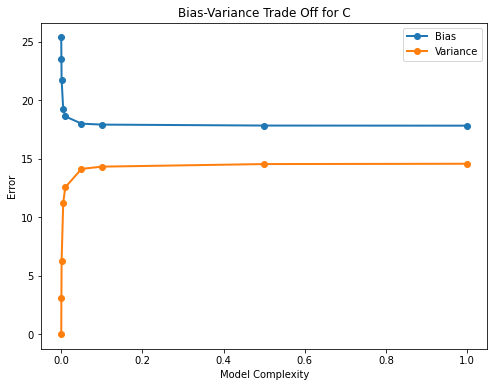

In [27]:
Bias = []
Variance = []
for i in range(len(outcomes)):
    Bias.append(outcomes[i][1])
    Variance.append(outcomes[i][2])
Bias = pd.DataFrame(Bias,index=C)
Variance = pd.DataFrame(Variance,index=C)
plt.figure(figsize=(8,6))
plt.plot(Bias, label="Bias",linewidth = 2, marker='o')
plt.plot(Variance, label="Variance", linewidth = 2,marker='o')
plt.legend()
plt.title("Bias-Variance Trade Off for C")
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.show()

In [28]:
# tune the hyperparameter solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
outcomes = []

for i in range(len(solver)):
    print("\nsolver = {}" .format(solver[i]))
    def_ = run_kfold(x_train, y_train, C_input = 1.0 ,penalty_input='l2',solver_input=solver[i])
    outcomes.append(def_)


solver = newton-cg
Average Train Accuracy 0.4719785297759817
Average Validation Accuracy 0.45898178283941893
Train Accuracy Variance 2.803865878709419e-06
Validation Accuracy Variance 0.0002059747047652797
Bias of Validation Prediction 17.818868434420406
Variance of Validation Prediction 14.55982974857363

solver = lbfgs
Average Train Accuracy 0.4719695053197052
Average Validation Accuracy 0.45898178283941893
Train Accuracy Variance 2.777522651088795e-06
Validation Accuracy Variance 0.0002059747047652797
Bias of Validation Prediction 17.818868434420406
Variance of Validation Prediction 14.55982974857363

solver = liblinear
Average Train Accuracy 0.4692801904714122
Average Validation Accuracy 0.4603626420289702
Train Accuracy Variance 3.497387816216595e-06
Validation Accuracy Variance 0.00019044140052144608
Bias of Validation Prediction 19.358817091482575
Variance of Validation Prediction 10.694368984426443

solver = sag
Average Train Accuracy 0.4719785297759817
Average Validation Accu

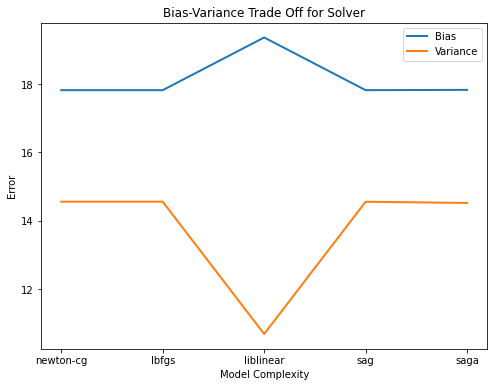

In [29]:
Bias = []
Variance = []
for i in range(len(outcomes)):
    Bias.append(outcomes[i][1])
    Variance.append(outcomes[i][2])
Bias = pd.DataFrame(Bias,index=solver)
Variance = pd.DataFrame(Variance,index=solver)
plt.subplots(figsize=(8,6))
plt.plot(Bias, label="Bias",linewidth = 2)
plt.plot(Variance, label="Variance", linewidth = 2)
plt.legend()
plt.title("Bias-Variance Trade Off for Solver")
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.show()

In [30]:
# tune the hyperparameter penalty
penalty = ['none','l2']
outcomes = []

for i in range(len(penalty)):
    print("\npenalty = {}" .format(penalty[i]))
    def_ = run_kfold(x_train, y_train, C_input = 1.0 ,penalty_input=penalty[i],solver_input='lbfgs')
    outcomes.append(def_)


penalty = none
Average Train Accuracy 0.47198755504673984
Average Validation Accuracy 0.4588193792397692
Train Accuracy Variance 2.7512372248837403e-06
Validation Accuracy Variance 0.00021129272407134013
Bias of Validation Prediction 17.808529375586225
Variance of Validation Prediction 14.591226822766766

penalty = l2
Average Train Accuracy 0.4719695053197052
Average Validation Accuracy 0.45898178283941893
Train Accuracy Variance 2.777522651088795e-06
Validation Accuracy Variance 0.0002059747047652797
Bias of Validation Prediction 17.818868434420406
Variance of Validation Prediction 14.55982974857363


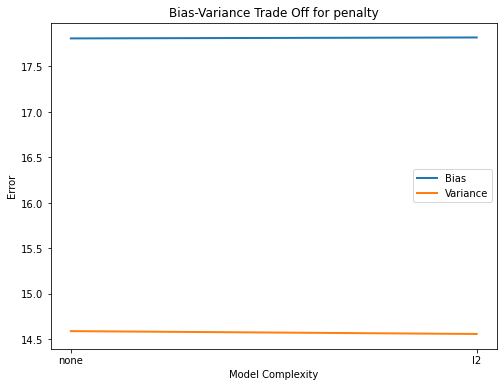

In [31]:
Bias = []
Variance = []
for i in range(len(outcomes)):
    Bias.append(outcomes[i][1])
    Variance.append(outcomes[i][2])
Bias = pd.DataFrame(Bias,index=penalty)
Variance = pd.DataFrame(Variance,index=penalty)
plt.figure(figsize=(8,6))
plt.plot(Bias, label="Bias",linewidth = 2)
plt.plot(Variance, label="Variance", linewidth = 2)
plt.legend()
plt.title("Bias-Variance Trade Off for penalty")
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.show()

## 4 Model Tuning

From the last section, chaning hyperparameter ‘C’ and ‘solver’ have a greater impact on the total error of the model than changing the hyperparameter ‘penalty’. Selected ‘C’ and ‘solver’ two hyperparameters for model tuning. Using grid search to find an optimal model from list of ‘C’ values: [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1] and list of ‘solver’ [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]. 
Using GridSearchCV() to try each combination of ‘C’ and ‘solver’ from the dictionary and evaluated the model using Cross-validation method. Accuracy and weighted F1-score will be monitored through evaluation, the model with highest accuracy will be selected as the optimal model. 

In [32]:
model = LogisticRegression()
grid = {'C':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model_cv = GridSearchCV(model, grid, cv=10, scoring = ['accuracy', 'f1_weighted'], refit='accuracy')
model_cv.fit(x_train,y_train)
print('Best parameters:', model_cv.best_params_)
print('Best Accuracy Score:', model_cv.score(x_train, y_train))

Best parameters: {'C': 0.005, 'solver': 'newton-cg'}
Best Accuracy Score: 0.46824236517218976


In [40]:
optimal_model = LogisticRegression(C=0.005,solver='newton-cg')
optimal_model.fit(x_train,y_train)
# get importance
importance = optimal_model.coef_[0]
importance = pd.DataFrame(importance,columns=["Importance"])
importance = importance.sort_values("Importance",ascending=False)

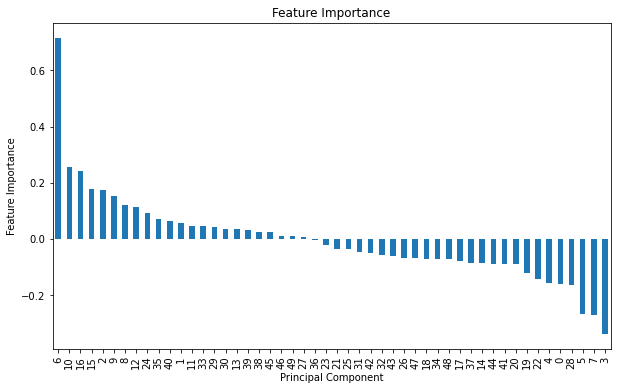

In [41]:
importance.plot(kind='bar',legend=None,figsize=(10,6))
plt.title('Feature Importance')
plt.xlabel('Principal Component')
plt.ylabel('Feature Importance')
plt.show()

From the results, the best parameters are ‘C’ = 0.005 and ‘solver’ = ‘newton-cg’. The highest accuracy is 46.824%.
The feature importance here is identified with coefficient. The plot shows that principal component 6 has the highest coefficient, which means that principal component 6 is the feature with strongest correlation with salary buckets. 

## 5 Testing & Discussion

In [42]:
optimal_model = LogisticRegression(C=0.005,solver='newton-cg')
optimal_model.fit(x_train,y_train)
train_predictions = optimal_model.predict(x_train)
test_predictions = optimal_model.predict(x_test)
print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

         0.0       0.52      0.96      0.68      1423
         1.0       0.05      0.00      0.01       281
         2.0       0.08      0.01      0.02       225
         3.0       0.12      0.01      0.01       153
         4.0       0.09      0.02      0.03       132
         5.0       0.21      0.03      0.05       140
         6.0       0.00      0.00      0.00        95
         7.0       0.00      0.00      0.00       103
         8.0       1.00      0.01      0.03        69
         9.0       0.00      0.00      0.00        74
        10.0       0.20      0.30      0.24       151
        11.0       0.15      0.06      0.08        70
        12.0       0.18      0.22      0.20        74
        13.0       0.20      0.02      0.04        49
        14.0       0.00      0.00      0.00        40

    accuracy                           0.47      3079
   macro avg       0.19      0.11      0.09      3079
weighted avg       0.31   

In [50]:
# Implement opitmal ordinal logistic regression algorithm
model = LogisticRegression(C=0.005,solver='newton-cg')
# 5-fold cross-validation.
kf = KFold(n_splits=5) #n_splits previously n_folds
# for loop setup
fold = 0
train_accur = []
test_accur = []
mae_train = []
mae_test = []
for train_index, test_index in kf.split(x):
    fold += 1
    x_train_kf, x_test_kf = x.values[train_index], x.values[test_index]
    y_train_kf, y_test_kf = y.values[train_index], y.values[test_index]

    # fit data using logistic regression model  
    model.fit(x_train_kf, y_train_kf)
    # prediction 
    train_predictions = model.predict(x_train_kf)
    test_predictions = model.predict(x_test_kf)
    # calculate accuracy using accuracy_score    
    test_accuracy = accuracy_score(y_test_kf, test_predictions) 
    train_accuracy = accuracy_score(y_train_kf, train_predictions) 
    
    mae_train.append(mean_absolute_error(y_train_kf, train_predictions))
    mae_test.append(mean_absolute_error(y_test_kf, test_predictions))

    test_accur.append(test_accuracy)
    train_accur.append(train_accuracy)
    print("Fold {0} |Train Accuracy: {1}|Test Accuracy {2}".format(fold, train_accuracy, test_accuracy))   
    # print("Fold {0} |Train MAE: {1}|Test MAE {2}".format(fold, mean_absolute_error(y_train_kf, train_predictions), 
                                                         # mean_absolute_error(y_test_kf, test_predictions)))

probabilities = pd.DataFrame(model.predict_proba(x_test_kf),columns=range(1,16))


train_avg = statistics.mean(train_accur) 
test_avg = statistics.mean(test_accur)

train_var = statistics.variance(train_accur)
test_var = statistics.variance(test_accur)

print('\nAverage Train Accuracy', train_avg)
print('Average Test  Accuracy', test_avg)
print('\nTrain Accuracy Variance', train_var)
print('Test Accuracy Variance', test_var)

Fold 1 |Train Accuracy: 0.46085120207927227|Test Accuracy 0.4667099707697304
Fold 2 |Train Accuracy: 0.46154470884431087|Test Accuracy 0.46523716699155293
Fold 3 |Train Accuracy: 0.46300657841305937|Test Accuracy 0.45938921377517866
Fold 4 |Train Accuracy: 0.4677982619995127|Test Accuracy 0.4441195581546459
Fold 5 |Train Accuracy: 0.4622756436286851|Test Accuracy 0.46263807667316437

Average Train Accuracy 0.46309527899296804
Average Test  Accuracy 0.45961879727285443

Train Accuracy Variance 7.5594670158990294e-06
Test Accuracy Variance 8.2811497445433e-05


Using KFold() to split the training and test sets with into 5 consecutive folds, which is equal to the test_size = 20%. Train the optimal model on training set and make classification on both training and test set. 
The average accuracy on training set is 46.309% and the average accuracy on testing set is 45.961%. The accuracies are very close, while the training set is slightly higher than test set. The accuracy of the model can be further improved by reduce to lower dimensionality or tuning more hyperparameters.

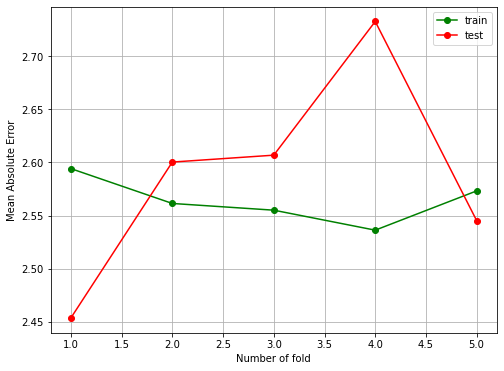

In [51]:
folds = range(1, kf.get_n_splits() + 1)
plt.figure(figsize=(8,6))
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()

To identify whether the optimal model is overfitting or underfitting, I plotted the Mean Absolute Error (MAE) for each fold. For most folds, the MAE of test set are higher than MAE of training set. Thus, the optimal model is overfitting. 

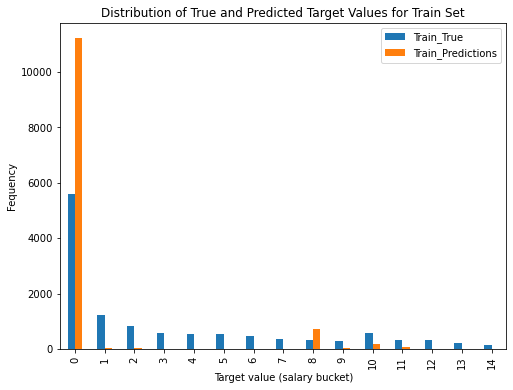

In [52]:
train = y_train.value_counts().sort_index()
pred = pd.Series(train_predictions).value_counts().sort_index()
train = pd.DataFrame(train)
train = train.reset_index(drop=True)
pred = pd.DataFrame(pred)
pred = pred.reset_index(drop=True)
df_train = pd.concat([train,pred],axis=1)
df_train.columns = ["Train_True","Train_Predictions"]
df_train.plot(kind='bar',figsize=(8,6))
plt.title('Distribution of True and Predicted Target Values for Train Set')
plt.xlabel('Target value (salary bucket)')
plt.ylabel('Fequency')
plt.show()

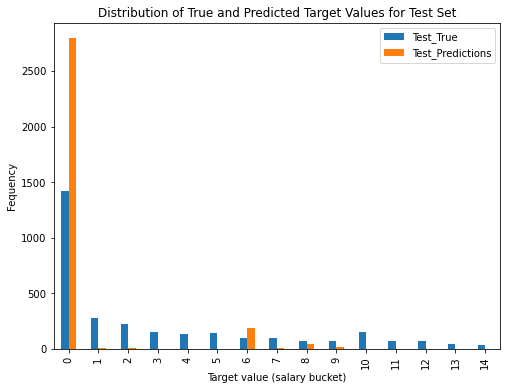

In [53]:
test = y_test.value_counts().sort_index()
pred = pd.Series(test_predictions).value_counts().sort_index()
test = pd.DataFrame(test)
test = test.reset_index(drop=True)
pred = pd.DataFrame(pred)
pred = pred.reset_index(drop=True)
df_test = pd.concat([test,pred],axis=1)
df_test.columns = ["Test_True","Test_Predictions"]
df_test.plot(kind='bar',figsize=(8,6))
plt.title('Distribution of True and Predicted Target Values for Test Set')
plt.xlabel('Target value (salary bucket)')
plt.ylabel('Fequency')
plt.show()

According to the distribution of true target variable values and their predictions, the true value’s distribution is right skewed as a lot of participants are in salary bucket 0. The figures showed that
the number of predictions in bucket 0 and bucket 8, exceed the true values for training. For test data, the number of predictions in bucket 0 and bucket 6, exceed the true values. Thus, the classification model is highly likely to distinguish the participant into very low salary bucket such as bucket 0 or to some middle level, such as bucket 8 or bucket 6.